In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from tensorflow.keras.utils import to_categorical
from scipy.stats import linregress
import sqlalchemy
from sqlalchemy import create_engine, func
from sqlalchemy.ext.automap import automap_base

# NOT UPLOADED TO GITHUB
from config import PASSWORD, USERNAME, DATABASE_NAME, ENDPOINT

2022-10-11 20:46:59.661055: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
engine = create_engine(f'postgresql+psycopg2://{USERNAME}:{PASSWORD}@{ENDPOINT}/{DATABASE_NAME}')
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()


['listings', 'calendar', 'reviews', 'listings_clean']

In [3]:
#Assigning tables to variables
listings = Base.classes.listings
calendar = Base.classes.calendar
reviews = Base.classes.reviews

In [4]:
session = Session(engine)
listings_id = session.query(listings.id)

sql_query_listings = pd.read_sql_query ('''
                               SELECT
                               *
                               FROM listings_clean
                               ''', engine)




In [5]:
df_list = pd.DataFrame(sql_query_listings, columns = sql_query_listings.keys())
df_list = df_list.rename(columns={'id': 'listing_id'})
df_list.head()

,listing_id,city,state,zipcode,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,review_scores_rating
0,241032,Seattle,WA,98119,47.636289,-122.371025,4,1.0,1.0,1.0,85.0,95.0
1,953595,Seattle,WA,98119,47.639123,-122.365666,4,1.0,1.0,1.0,150.0,96.0
2,3308979,Seattle,WA,98119,47.629724,-122.369483,11,4.5,5.0,7.0,975.0,97.0
3,278830,Seattle,WA,98119,47.632918,-122.372471,6,2.0,3.0,3.0,450.0,92.0
4,5956968,Seattle,WA,98119,47.630525,-122.366174,2,1.0,1.0,1.0,120.0,95.0


In [6]:
sql_query_calendar = pd.read_sql_query ('''
                               SELECT
                               *
                               FROM calendar_clean
                               ''', engine)

df_cal = pd.DataFrame(sql_query_calendar, columns = sql_query_calendar.keys())
df_cal.head()

,listing_id,date,available,price
0,241032,1,t,85.0
1,241032,1,t,85.0
2,241032,1,t,85.0
3,241032,1,t,85.0
4,241032,1,t,85.0


In [7]:
df_cal_g = df_cal.groupby(['listing_id','date']).mean()
df_cal_g

price
listing_id date       
3335       1     120.0
           2     120.0
           3     120.0
           4     120.0
           5     120.0
...                ...
10340165   8      43.0
           9      43.0
           10     43.0
           11     43.0
           12     43.0

[33939 rows x 1 columns]

In [8]:
df_cal_g = df_cal_g.reset_index(level=['date'])
df_cal_g.head()

,date,price
listing_id,,
3335,1,120.0
3335,2,120.0
3335,3,120.0
3335,4,120.0
3335,5,120.0


In [9]:
df = df_list.merge(df_cal_g, how='inner', on='listing_id')
df.head()

,listing_id,city,state,zipcode,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price_x,review_scores_rating,date,price_y
0,241032,Seattle,WA,98119,47.636289,-122.371025,4,1.0,1.0,1.0,85.0,95.0,1,85.0
1,241032,Seattle,WA,98119,47.636289,-122.371025,4,1.0,1.0,1.0,85.0,95.0,2,85.0
2,241032,Seattle,WA,98119,47.636289,-122.371025,4,1.0,1.0,1.0,85.0,95.0,3,85.0
3,241032,Seattle,WA,98119,47.636289,-122.371025,4,1.0,1.0,1.0,85.0,95.0,4,85.0
4,241032,Seattle,WA,98119,47.636289,-122.371025,4,1.0,1.0,1.0,85.0,95.0,5,85.0


In [10]:
df.rename(columns={"price_y":'price','date':'month'}, inplace=True)
df.head()

,listing_id,city,state,zipcode,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price_x,review_scores_rating,month,price
0,241032,Seattle,WA,98119,47.636289,-122.371025,4,1.0,1.0,1.0,85.0,95.0,1,85.0
1,241032,Seattle,WA,98119,47.636289,-122.371025,4,1.0,1.0,1.0,85.0,95.0,2,85.0
2,241032,Seattle,WA,98119,47.636289,-122.371025,4,1.0,1.0,1.0,85.0,95.0,3,85.0
3,241032,Seattle,WA,98119,47.636289,-122.371025,4,1.0,1.0,1.0,85.0,95.0,4,85.0
4,241032,Seattle,WA,98119,47.636289,-122.371025,4,1.0,1.0,1.0,85.0,95.0,5,85.0


In [11]:
df.drop(columns=['state','listing_id','price_x'], inplace=True)

In [12]:
df.head()

,city,zipcode,latitude,longitude,accommodates,bathrooms,bedrooms,beds,review_scores_rating,month,price
0,Seattle,98119,47.636289,-122.371025,4,1.0,1.0,1.0,95.0,1,85.0
1,Seattle,98119,47.636289,-122.371025,4,1.0,1.0,1.0,95.0,2,85.0
2,Seattle,98119,47.636289,-122.371025,4,1.0,1.0,1.0,95.0,3,85.0
3,Seattle,98119,47.636289,-122.371025,4,1.0,1.0,1.0,95.0,4,85.0
4,Seattle,98119,47.636289,-122.371025,4,1.0,1.0,1.0,95.0,5,85.0


In [13]:
df.price.min()

20.0

(array([2.0000e+00, 0.0000e+00, 0.0000e+00, 2.6000e+01, 0.0000e+00,
        8.0000e+00, 8.0000e+00, 1.2300e+02, 1.8200e+02, 2.3200e+02,
        1.1420e+03, 1.7220e+03, 6.9350e+03, 1.8073e+04]),
 array([ 20.        ,  25.71428571,  31.42857143,  37.14285714,
         42.85714286,  48.57142857,  54.28571429,  60.        ,
         65.71428571,  71.42857143,  77.14285714,  82.85714286,
         88.57142857,  94.28571429, 100.        ]),
 <BarContainer object of 14 artists>)

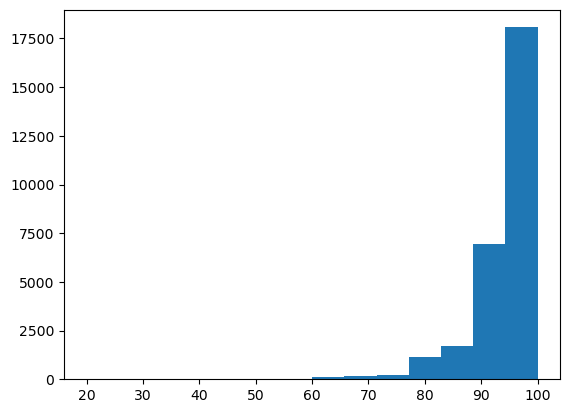

In [14]:
plt.hist(df['review_scores_rating'], bins=14)

(array([2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 2.6000e+01, 0.0000e+00, 1.2000e+01, 1.0300e+02,
        1.8300e+02, 3.1400e+02, 3.2470e+03, 2.4566e+04]),
 array([1.30103   , 1.35095642, 1.40088285, 1.45080928, 1.50073571,
        1.55066214, 1.60058857, 1.650515  , 1.70044143, 1.75036786,
        1.80029428, 1.85022071, 1.90014714, 1.95007357, 2.        ]),
 <BarContainer object of 14 artists>)

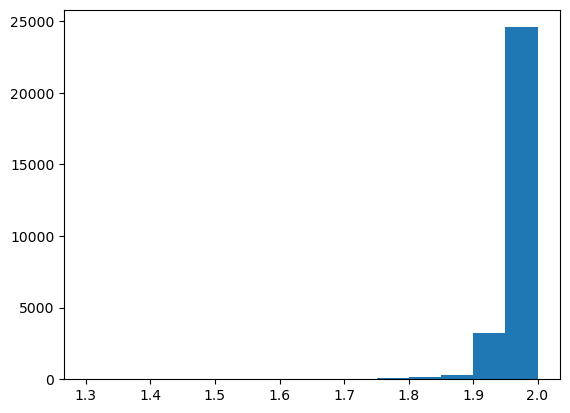

In [15]:
plt.hist(df['review_scores_rating'].apply(np.log10), bins=14)

In [16]:
# df['review_scores_rating'] = df['review_scores_rating'].apply(np.log10)

(array([21084.,  4754.,  2381.,   167.,    67.]),
 array([0. , 1.4, 2.8, 4.2, 5.6, 7. ]),
 <BarContainer object of 5 artists>)

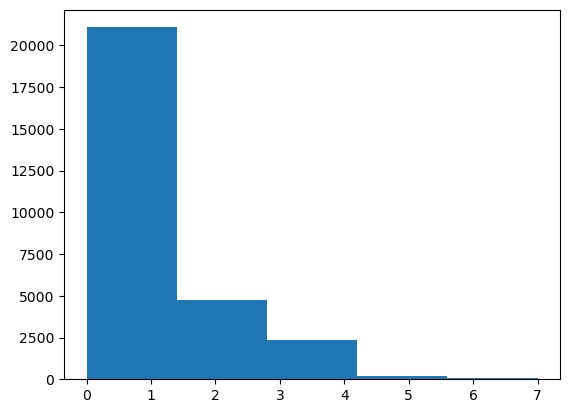

In [17]:
plt.hist(df['bedrooms'], bins=5)

(array([ 2680., 18404.,  4754.,  2381.,   234.]),
 array([0.        , 0.52915026, 1.05830052, 1.58745079, 2.11660105,
        2.64575131]),
 <BarContainer object of 5 artists>)

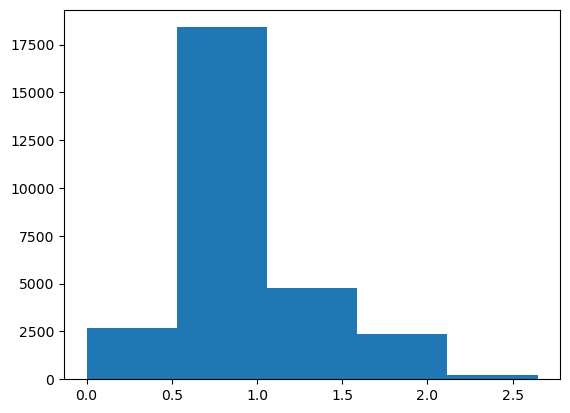

In [18]:
plt.hist(df['bedrooms'].apply(np.sqrt), bins=5)

In [19]:
df['bedrooms']=df['bedrooms'].apply(np.sqrt)

(array([2.3801e+04, 4.0490e+03, 5.7400e+02, 2.4000e+01, 5.0000e+00]),
 array([0. , 1.6, 3.2, 4.8, 6.4, 8. ]),
 <BarContainer object of 5 artists>)

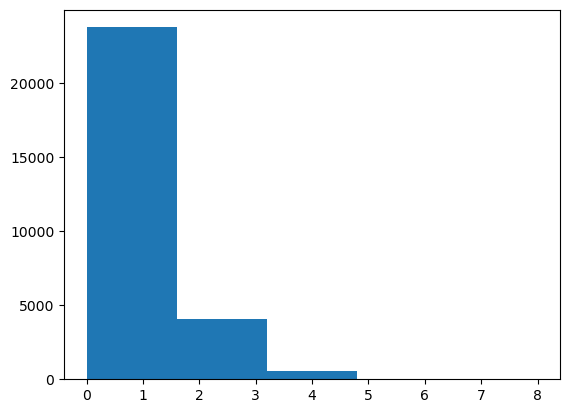

In [20]:
plt.hist(df['bathrooms'], bins=5)

(array([   38.,   226., 23537.,  4594.,    58.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. ]),
 <BarContainer object of 5 artists>)

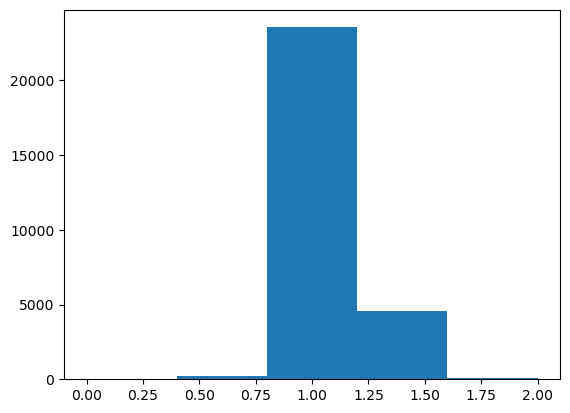

In [21]:
plt.hist(df['bathrooms'].apply(lambda x: pow(x,1/3)), bins=5)

In [22]:
df['bathrooms'] = df['bathrooms'].apply(lambda x: pow(x,1/3))

(array([16953.,  9794.,  1253.,   373.,    80.]),
 array([ 1.,  4.,  7., 10., 13., 16.]),
 <BarContainer object of 5 artists>)

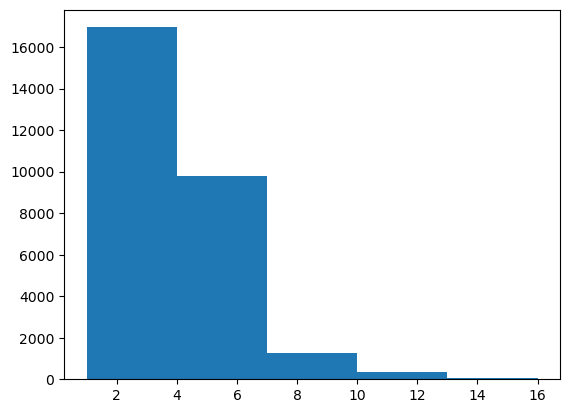

In [23]:
plt.hist(df['accommodates'], bins=5)

(array([ 1786., 15167.,  7163.,  3884.,   453.]),
 array([0.        , 0.240824  , 0.48164799, 0.72247199, 0.96329599,
        1.20411998]),
 <BarContainer object of 5 artists>)

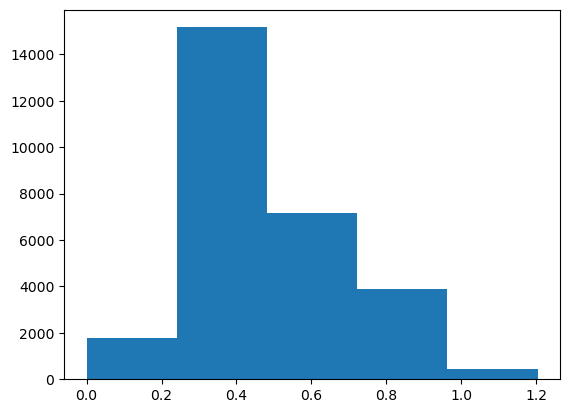

In [24]:
plt.hist(df['accommodates'].apply(np.log10), bins=5)

In [25]:
df['accommodates']=df['accommodates'].apply(np.log10)

(array([2.753e+04, 6.620e+02, 1.990e+02, 2.600e+01, 2.400e+01, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.200e+01]),
 array([  1. ,  23.4,  45.8,  68.2,  90.6, 113. , 135.4, 157.8, 180.2,
        202.6, 225. ]),
 <BarContainer object of 10 artists>)

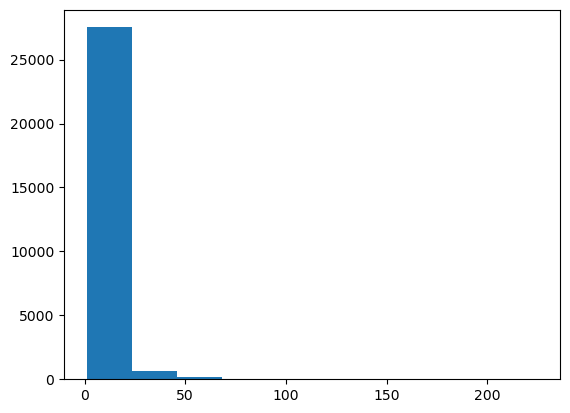

In [26]:
plt.hist(df.beds.apply(lambda x: pow(x,2)), bins =10)

In [27]:
# df.beds = df.beds.apply(lambda x: pow(x,2))

In [28]:
enc = OneHotEncoder(sparse=False)
encode_df = pd.DataFrame(enc.fit_transform(df[['city','zipcode','month']]))
encode_df.columns = enc.get_feature_names(['city','zipcode','month'])

/Users/johnwhendricks/opt/anaconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [29]:
df = df.merge(encode_df, left_index=True, right_index=True)
df.drop(columns=['city','zipcode','month'], inplace=True)

In [30]:
df.head()

,latitude,longitude,accommodates,bathrooms,bedrooms,beds,review_scores_rating,price,"city_Ballard, Seattle",city_Phinney Ridge Seattle,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,47.636289,-122.371025,0.60206,1.0,1.0,1.0,95.0,85.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,47.636289,-122.371025,0.60206,1.0,1.0,1.0,95.0,85.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,47.636289,-122.371025,0.60206,1.0,1.0,1.0,95.0,85.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,47.636289,-122.371025,0.60206,1.0,1.0,1.0,95.0,85.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,47.636289,-122.371025,0.60206,1.0,1.0,1.0,95.0,85.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
X = df.drop(columns=['price'])
y = df['price']

In [32]:
print(X.shape)
print(y.shape)

(28453, 52)
(28453,)


In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [34]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [35]:
X_train_scaled

array([[ 0.95077008, -1.00774725,  0.59283837, ..., -0.29185791,
        -0.29402689, -0.29861187],
       [ 0.62795198,  0.49742088, -0.69692246, ..., -0.29185791,
        -0.29402689, -0.29861187],
       [-2.54393585, -1.00715185, -0.69692246, ..., -0.29185791,
        -0.29402689, -0.29861187],
       ...,
       [-0.21046121, -0.18793781, -0.69692246, ..., -0.29185791,
        -0.29402689, -0.29861187],
       [-0.40842241, -0.47050455, -1.98668328, ..., -0.29185791,
        -0.29402689, -0.29861187],
       [-0.96484442, -1.84247265, -0.69692246, ..., -0.29185791,
        -0.29402689, -0.29861187]])

In [36]:
y_train

1052     142.225806
5457      55.000000
16308     70.000000
21206    149.000000
16665     61.612903
            ...    
26398    133.200000
10224    135.517241
8720     220.000000
9156      45.000000
13475    130.185185
Name: price, Length: 21339, dtype: float64

In [37]:
input_dim = X.shape[1]

model = Sequential([
    Dense(200, input_dim = input_dim, activation='relu'),
    Dense(100, activation='relu'),
    Dense(50, activation='relu'),
    Dense(25, activation='relu'),
    Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               10600     
                                                                 
 dense_1 (Dense)             (None, 100)               20100     
                                                                 
 dense_2 (Dense)             (None, 50)                5050      
                                                                 
 dense_3 (Dense)             (None, 25)                1275      
                                                                 
 dense_4 (Dense)             (None, 1)                 26        
                                                                 
Total params: 37,051
Trainable params: 37,051
Non-trainable params: 0
_________________________________________________________________


2022-10-11 20:47:15.899553: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


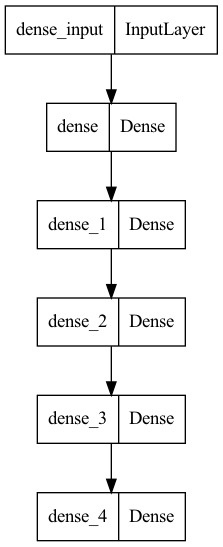

In [38]:
tf.keras.utils.plot_model(model)

In [39]:
model.compile(optimizer='adam',loss='mse')

In [40]:
history = model.fit(X_train_scaled, y_train, epochs=500, 
                    validation_data=(X_test_scaled, y_test), 
                    callbacks=[
                        tf.keras.callbacks.ModelCheckpoint('model.hdf5', 
                            save_weights_only=True, save_best_only=True)
                    ])

Epoch 1/500
667/667 [==============================] - 2s 3ms/step - loss: 5863.7241 - val_loss: 3884.3296
Epoch 2/500
667/667 [==============================] - 1s 2ms/step - loss: 3900.2537 - val_loss: 3769.6655
Epoch 3/500
667/667 [==============================] - 1s 2ms/step - loss: 3776.2217 - val_loss: 3757.3828
Epoch 4/500
667/667 [==============================] - 1s 2ms/step - loss: 3708.8430 - val_loss: 3535.9504
Epoch 5/500
667/667 [==============================] - 1s 2ms/step - loss: 3591.3608 - val_loss: 3622.1890
Epoch 6/500
667/667 [==============================] - 1s 2ms/step - loss: 3512.0967 - val_loss: 3383.1519
Epoch 7/500
667/667 [==============================] - 1s 2ms/step - loss: 3419.1416 - val_loss: 3269.0024
Epoch 8/500
667/667 [==============================] - 2s 2ms/step - loss: 3345.6555 - val_loss: 3201.1990
Epoch 9/500
667/667 [==============================] - 1s 2ms/step - loss: 3251.0896 - val_loss: 3128.0383
Epoch 10/500
667/667 [===============

667/667 [==============================] - 2s 3ms/step - loss: 351.3637 - val_loss: 860.6833
Epoch 154/500
667/667 [==============================] - 2s 3ms/step - loss: 337.6168 - val_loss: 936.0013
Epoch 155/500
667/667 [==============================] - 2s 2ms/step - loss: 363.6416 - val_loss: 891.4488
Epoch 156/500
667/667 [==============================] - 2s 3ms/step - loss: 361.8265 - val_loss: 875.4006
Epoch 157/500
667/667 [==============================] - 2s 3ms/step - loss: 322.5924 - val_loss: 856.3218
Epoch 158/500
667/667 [==============================] - 2s 3ms/step - loss: 329.5759 - val_loss: 806.5925
Epoch 159/500
667/667 [==============================] - 1s 2ms/step - loss: 365.4619 - val_loss: 982.2462
Epoch 160/500
667/667 [==============================] - 2s 3ms/step - loss: 338.8133 - val_loss: 831.5921
Epoch 161/500
667/667 [==============================] - 2s 2ms/step - loss: 336.7973 - val_loss: 979.7039
Epoch 162/500
667/667 [============================

667/667 [==============================] - 1s 2ms/step - loss: 192.3750 - val_loss: 738.8409
Epoch 306/500
667/667 [==============================] - 1s 2ms/step - loss: 175.2144 - val_loss: 701.6443
Epoch 307/500
667/667 [==============================] - 1s 2ms/step - loss: 155.6500 - val_loss: 687.7643
Epoch 308/500
667/667 [==============================] - 1s 2ms/step - loss: 169.6671 - val_loss: 705.6830
Epoch 309/500
667/667 [==============================] - 1s 2ms/step - loss: 189.5948 - val_loss: 730.1894
Epoch 310/500
667/667 [==============================] - 1s 2ms/step - loss: 168.8622 - val_loss: 693.3029
Epoch 311/500
667/667 [==============================] - 1s 2ms/step - loss: 162.7683 - val_loss: 765.7610
Epoch 312/500
667/667 [==============================] - 1s 2ms/step - loss: 163.8047 - val_loss: 704.8530
Epoch 313/500
667/667 [==============================] - 1s 2ms/step - loss: 169.8576 - val_loss: 681.8022
Epoch 314/500
667/667 [============================

667/667 [==============================] - 1s 2ms/step - loss: 112.5422 - val_loss: 633.3844
Epoch 458/500
667/667 [==============================] - 1s 2ms/step - loss: 115.2086 - val_loss: 615.0413
Epoch 459/500
667/667 [==============================] - 2s 2ms/step - loss: 112.6079 - val_loss: 639.4871
Epoch 460/500
667/667 [==============================] - 1s 2ms/step - loss: 115.7799 - val_loss: 651.0173
Epoch 461/500
667/667 [==============================] - 1s 2ms/step - loss: 121.1797 - val_loss: 647.2360
Epoch 462/500
667/667 [==============================] - 1s 2ms/step - loss: 128.6707 - val_loss: 653.7161
Epoch 463/500
667/667 [==============================] - 1s 2ms/step - loss: 105.9043 - val_loss: 623.7208
Epoch 464/500
667/667 [==============================] - 1s 2ms/step - loss: 112.6802 - val_loss: 624.9186
Epoch 465/500
667/667 [==============================] - 1s 2ms/step - loss: 118.4532 - val_loss: 625.7392
Epoch 466/500
667/667 [============================

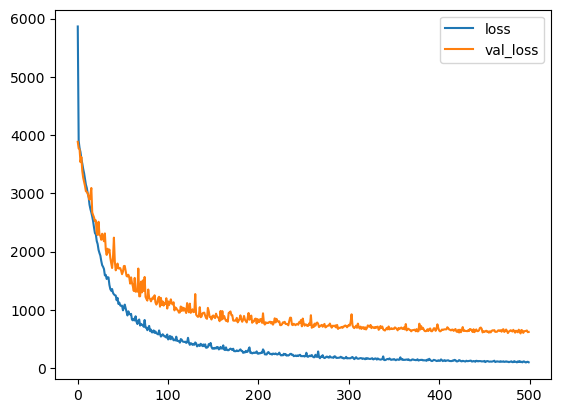

In [41]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(loss, label='loss')
plt.plot(val_loss, label='val_loss')
plt.legend()
plt.show()

In [42]:
model.load_weights('model.hdf5')
y_pred = model.predict(X_test_scaled)

223/223 [==============================] - 0s 1ms/step


Text(0.5, 0, 'predicted price')

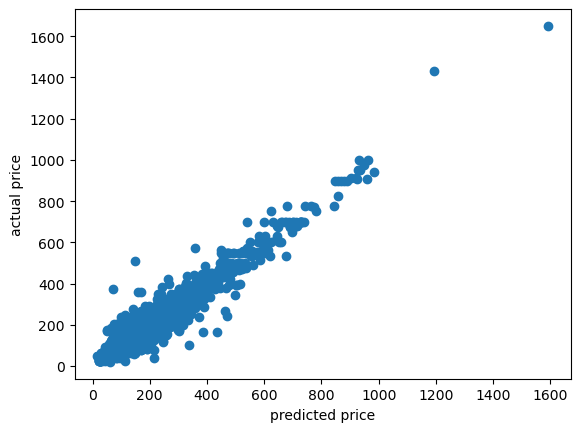

In [43]:
plt.scatter(y_pred, y_test)
plt.ylabel('actual price')
plt.xlabel('predicted price')

In [44]:
y_pred.tolist()

[[89.31927490234375],
 [211.24966430664062],
 [93.4393081665039],
 [48.71065902709961],
 [85.0896224975586],
 [98.47142791748047],
 [77.12000274658203],
 [124.92976379394531],
 [196.1412811279297],
 [74.8747329711914],
 [162.1613311767578],
 [189.89862060546875],
 [112.30089569091797],
 [196.81036376953125],
 [163.8908233642578],
 [264.8114013671875],
 [116.61071014404297],
 [57.919124603271484],
 [154.26812744140625],
 [72.9666519165039],
 [242.70840454101562],
 [124.94596862792969],
 [92.59070587158203],
 [309.3708801269531],
 [85.6133041381836],
 [162.07919311523438],
 [281.7534484863281],
 [60.34477615356445],
 [119.63549041748047],
 [81.70862579345703],
 [59.55729675292969],
 [135.16162109375],
 [39.92182159423828],
 [97.62382507324219],
 [218.2263946533203],
 [69.5077896118164],
 [964.0972900390625],
 [27.380962371826172],
 [57.94154357910156],
 [126.09244537353516],
 [675.5830078125],
 [70.84510040283203],
 [149.6671142578125],
 [108.72459411621094],
 [929.5185546875],
 [64.7280

In [45]:
y_test.values.tolist()

[75.0,
 225.0,
 110.0,
 55.0,
 87.09677419354838,
 100.66666666666667,
 73.7741935483871,
 170.0,
 180.0,
 91.0,
 160.0,
 195.0,
 130.89655172413794,
 250.0,
 150.0,
 270.6896551724138,
 109.5,
 62.53333333333333,
 134.0,
 60.6,
 217.29032258064515,
 134.80645161290323,
 80.0,
 325.0,
 86.45161290322581,
 149.0,
 311.6333333333333,
 62.064516129032256,
 126.45161290322581,
 70.45161290322581,
 45.766666666666666,
 135.0,
 40.61290322580645,
 103.0909090909091,
 189.0,
 75.0,
 999.0,
 25.0,
 69.0,
 125.0,
 533.3333333333334,
 69.0,
 124.0,
 120.0,
 950.0,
 65.0,
 240.0344827586207,
 105.0,
 127.58064516129032,
 100.0,
 50.0,
 150.0,
 91.61290322580645,
 155.0,
 113.09677419354838,
 212.90322580645162,
 77.0,
 101.0,
 90.0,
 90.0,
 28.466666666666665,
 146.1290322580645,
 81.37931034482759,
 120.0,
 128.7,
 62.903225806451616,
 69.0,
 130.80645161290323,
 450.0,
 190.0,
 144.6,
 50.0,
 60.0,
 212.86666666666667,
 109.0,
 74.16129032258064,
 72.58064516129032,
 44.0,
 82.86666666666666,
 

In [46]:
results_df = pd.DataFrame({'predicted price':y_pred[:,0]})
results_df.head()

,predicted price
0,89.319275
1,211.249664
2,93.439308
3,48.710659
4,85.089622


In [47]:
results_df['actual price'] = y_test.values

In [48]:
results_df.head(20)

,predicted price,actual price
0,89.319275,75.000000
1,211.249664,225.000000
2,93.439308,110.000000
3,48.710659,55.000000
4,85.089622,87.096774
5,98.471428,100.666667
6,77.120003,73.774194
7,124.929764,170.000000
8,196.141281,180.000000
9,74.874733,91.000000


In [49]:
results_df['diff'] = abs(results_df['predicted price'] - results_df['actual price'])
results_df

,predicted price,actual price,diff
0,89.319275,75.000000,14.319275
1,211.249664,225.000000,13.750336
2,93.439308,110.000000,16.560692
3,48.710659,55.000000,6.289341
4,85.089622,87.096774,2.007152
...,...,...,...
7109,75.145409,90.000000,14.854591
7110,64.814079,65.000000,0.185921
7111,72.763527,78.000000,5.236473
7112,343.538757,298.125000,45.413757


In [50]:
rmse = np.sqrt(history.history['val_loss'][-1])
diffs = results_df['diff'].sum() / results_df.shape[0]
results_df['lower'] = round(results_df['predicted price'] - 2*rmse)
results_df['upper'] = round(results_df['predicted price'] + 2*rmse)

results_df.loc[results_df['lower'] < 20, 'lower'] = 20

results_df['accurate'] = (results_df['lower'] <= results_df['actual price']) & (results_df['actual price'] <= results_df['upper']) 
results_df.tail()

,predicted price,actual price,diff,lower,upper,accurate
7109,75.145409,90.000,14.854591,25.0,125.0,True
7110,64.814079,65.000,0.185921,20.0,115.0,True
7111,72.763527,78.000,5.236473,23.0,123.0,True
7112,343.538757,298.125,45.413757,294.0,393.0,True
7113,393.507416,375.000,18.507416,344.0,443.0,True


In [51]:
results_df.head(20)

,predicted price,actual price,diff,lower,upper,accurate
0,89.319275,75.000000,14.319275,39.0,139.0,True
1,211.249664,225.000000,13.750336,161.0,261.0,True
2,93.439308,110.000000,16.560692,44.0,143.0,True
3,48.710659,55.000000,6.289341,20.0,99.0,True
4,85.089622,87.096774,2.007152,35.0,135.0,True
5,98.471428,100.666667,2.195239,49.0,148.0,True
6,77.120003,73.774194,3.345809,27.0,127.0,True
7,124.929764,170.000000,45.070236,75.0,175.0,True
8,196.141281,180.000000,16.141281,146.0,246.0,True
9,74.874733,91.000000,16.125267,25.0,125.0,True


In [52]:
results_df[results_df['accurate'] == False]

,predicted price,actual price,diff,lower,upper,accurate
13,196.810364,250.000000,53.189636,147.0,247.0,False
40,675.583008,533.333333,142.249674,626.0,725.0,False
53,87.047897,155.000000,67.952103,37.0,137.0,False
72,115.875916,60.000000,55.875916,66.0,166.0,False
108,241.584579,159.666667,81.917913,192.0,291.0,False
...,...,...,...,...,...,...
7060,143.248642,88.500000,54.748642,93.0,193.0,False
7067,65.913376,120.000000,54.086624,20.0,116.0,False
7070,149.648544,260.000000,110.351456,100.0,200.0,False
7078,331.218262,436.333333,105.115072,281.0,381.0,False


In [53]:
results_df['accurate'].value_counts()

True     6785
False     329
Name: accurate, dtype: int64

In [54]:
results_df['accurate'].value_counts()[1] / results_df['accurate'].value_counts().sum()

0.9537531627776216

In [55]:
_, _, r_value, _, _ = linregress(results_df['predicted price'].values,results_df['actual price'].values)

In [56]:
print('r value:',r_value)

r value: 0.97263690754835
